# Fourier sine series

Consider the sine functions $\sin(n\pi x)$ for $n=1,2,\ldots$ on the interval $x \in [0,1]$, with the "usual" function inner product $f(x) \cdot g(x) = \int_0^1 f(x) g(x) \, dx$.  It is a remarkable fact that the sine functions are **orthogonal** under this dot product:

$$
\sin(m\pi x) \cdot \sin(n\pi x) = \int_0^1 \sin(m\pi x) \sin(n\pi x) \, dx = \begin{cases} 0 & m \ne n \\ \frac{1}{2} & m = n \end{cases} .
$$

This can be verified by simply doing the integral, a first-year calculus exercise.  (The identity $\sin A \sin B = \frac{1}{2}[\cos (A-B) - \cos(A+B)]$ is useful here.)

Let's plot a few of these functions:

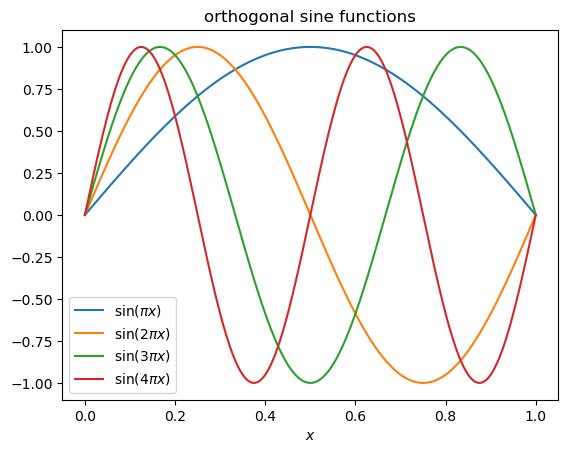

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /Users/stevenj/.julia/packages/PyCall/L0fLP/src/numpy.jl:67


PyObject Text(0.5, 1.0, 'orthogonal sine functions')

In [1]:
using PyPlot
x = range(0,1,length=200)
plot(x, sin.(π*x), "-")
plot(x, sin.(2π*x), "-")
plot(x, sin.(3π*x), "-")
plot(x, sin.(4π*x), "-")
legend([L"\sin(\pi x)", L"\sin(2\pi x)", L"\sin(3\pi x)", L"\sin(4\pi x)"])
xlabel(L"x")
title("orthogonal sine functions")

## Sines as an orthogonal basis

We can consider the $\sin(n\pi x)$ functions as an orthogonal basis for some set of functions, defined by all linear combinations of these $\sin(n\pi x)$ functions (their **span**).  At first glance, it seems like this should be a rather "small" subspace of all functions.  One of the most remarkable facts of mathematics, however, is that the span of the sine functions contains nearly all possible functions of practical interest!  This was first proposed by Fourier in 1807, but took almost 150 years to make rigorous and precise.

For a function $f(x)$ defined on $x \in [0,1]$, the [Fourier sine series](http://en.wikipedia.org/wiki/Fourier_sine_and_cosine_series) writes $f(x)$ as:
$$
f(x) = \sum_{n=1}^\infty b_n \sin(n\pi x)
$$
where the coefficients $b_n$ can be found by integration:
$$
b_m = 2 \int_0^1 f(x) \sin(m\pi x) dx \, .
$$

Let's define a function `sinecoef` in [Julia](http://julialang.org) to compute these [integrals numerically](http://en.wikipedia.org/wiki/Numerical_integration), using Julia's [quadgk](https://github.com/JuliaMath/QuadGK.jl) function  We'll use the `abstol` parameter to set an integration tolerance: we want the error to be small compared to $\sqrt{\int_0^1 |f(x)|^2 dx}$.

In [2]:
using QuadGK

sinecoef(f, m) = 2 * quadgk(x -> f(x) * sin(m*π*x), 0,1, atol=1e-8 * sqrt(quadgk(x->abs2(f(x)),0,1)[1]))[1]

sinecoef (generic function with 1 method)

## Truncated series = Projection = Fitting!

In practice, of course, we are usually forced to truncate the series to a finite number N of terms:

$$
f(x) \approx \sum_{n=1}^N b_n \sin(n\pi x)
$$

while still computing $b_m = 2 \int_0^1 f(x) \sin(m\pi x) dx$ as above.  The key thing to understand is that **this is orthogonal projection** of $f(x)$ onto the **N-dimensional subspace** spanned by $\{\sin(\pi x), \sin(2\pi x), \ldots, \sin(N\pi x)\}$.

And, just for projection with vectors in $\mathbb{R}^m$, **projection is equivalent to least-square fitting**.  That means that truncating the Fourier series is equivalent to finding the $b_n$ that **minimize**
$$
\left\Vert f(x) - \sum_{n=1}^N b_n \sin(n\pi x) \right\Vert^2 = \int_0^1 \left| f(x) - \sum_{n=1}^N b_n \sin(n\pi x) \right|^2 dx
$$
over all possible $\{b_1,\ldots,b_N\}$.

## A sine-series example

For example, if we have the function $f(x) = 0.5 - |x - 0.5|$, the first 20 coefficients are:

In [3]:
f(x) = 0.5 - abs(x - 0.5)
sinecoef.(f, 1:20)

20-element Vector{Float64}:
  0.4052847345693511
  5.031872079333402e-18
 -0.045031637174372426
  1.821156848822449e-17
  0.016211389382773993
 -2.0848986065940786e-17
 -0.008271117032027663
 -1.2554430899086627e-17
  0.005003515241596977
  4.703324618594227e-17
 -0.0033494606162756263
 -7.308916560896717e-18
  0.0023981345240789223
 -2.3414712309558446e-16
 -0.0018012654869748413
 -8.725341965181291e-17
  0.0014023693237693808
  3.6769709280601687e-16
 -0.0011226723949289694
 -4.114118967289368e-16

(Notice that $b_n = 0$ for *even* $n$, which correspond to *antisymmetric* sine functions that integrate to zero against this *symmetric* $f$.)   The coefficients seem to be converging (getting smaller), as we would hope for a convergent series.  Let's plot them.

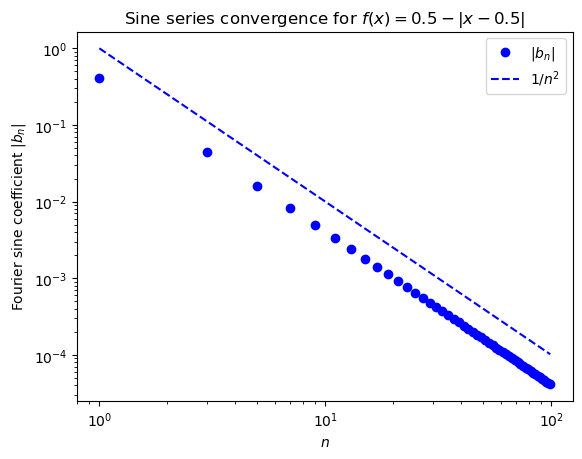

PyObject <matplotlib.legend.Legend object at 0x7fd6ef7b4850>

In [4]:
using PyPlot
n = 1:2:99 # odd integers from 1 to 99
loglog(n, abs.(sinecoef.(f, n)), "bo")
xlabel(L"n")
ylabel(L"Fourier sine coefficient $|b_n|$")
title(L"Sine series convergence for $f(x) = 0.5 - |x - 0.5|$")
loglog(n, 1 ./ n.^2, "b--")
legend([L"|b_n|", L"1/n^2"])

They decay asymptotically as $1/n^2$.  It turns out that one can prove this from the fact that $f(x)$ is continuous with a discontinuous slope.

Now let's plot the series itself and compare it to $f(x)$.  We'll use Julia's [Interact package](https://github.com/JuliaLang/Interact.jl) so that we can drag a slider to control the number of terms in the series.

In [5]:
# First, define a function to evaluate N terms of the sine series, given the coefficients b
function sinesum(b, x)
    f = 0.0
    for n = 1:length(b)
        f += b[n] * sin(n*π*x)
    end
    return f
end

sinesum (generic function with 1 method)

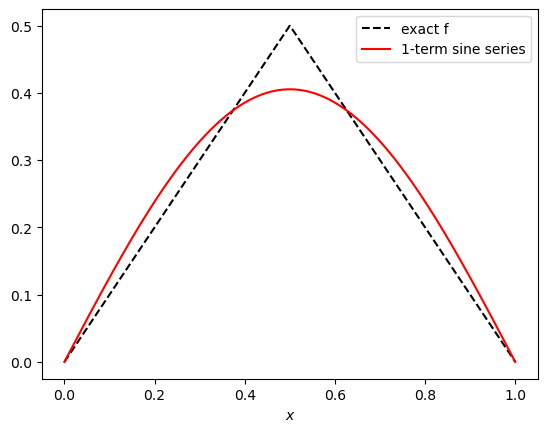

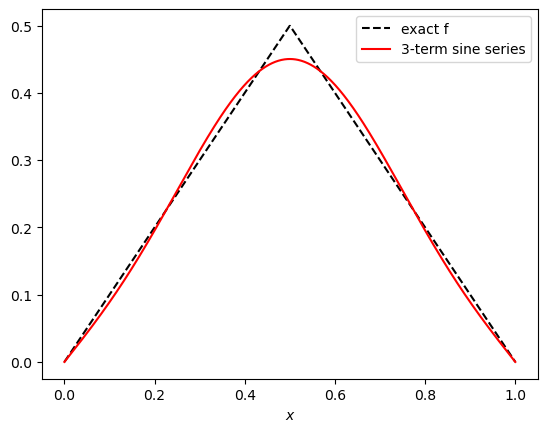

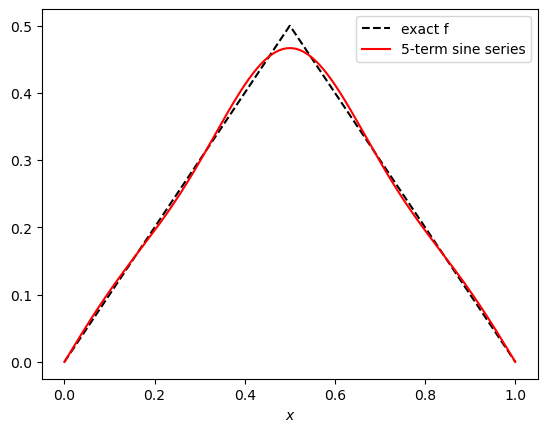

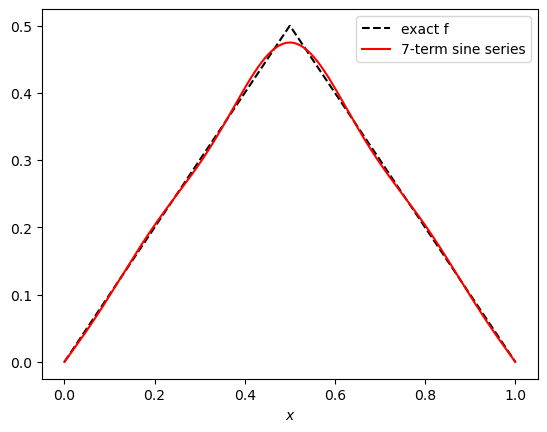

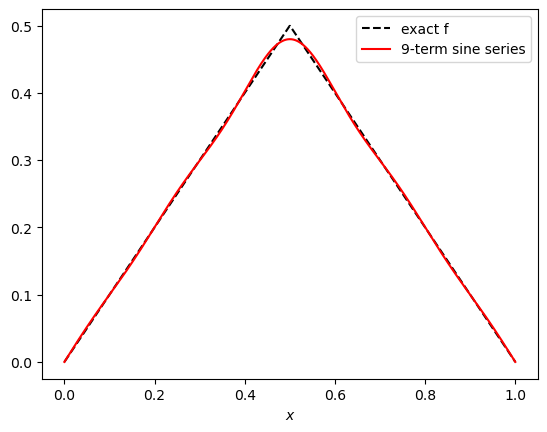

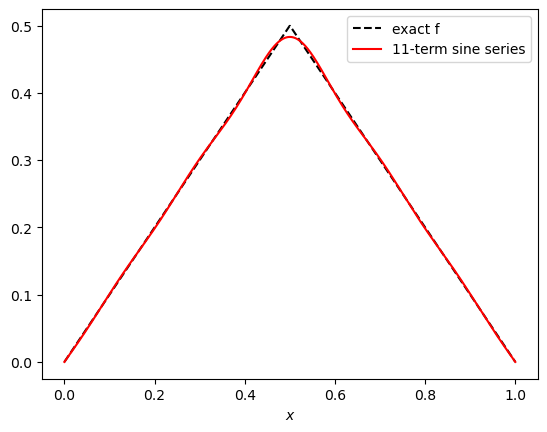

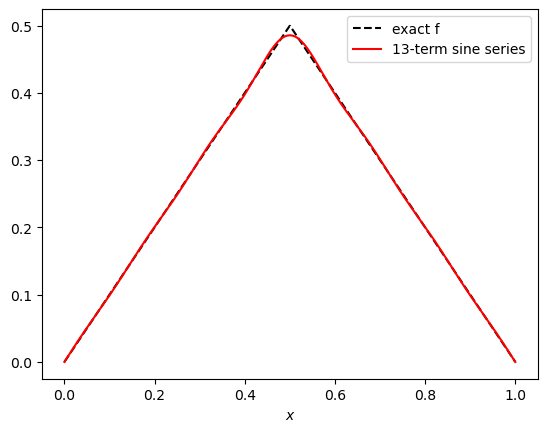

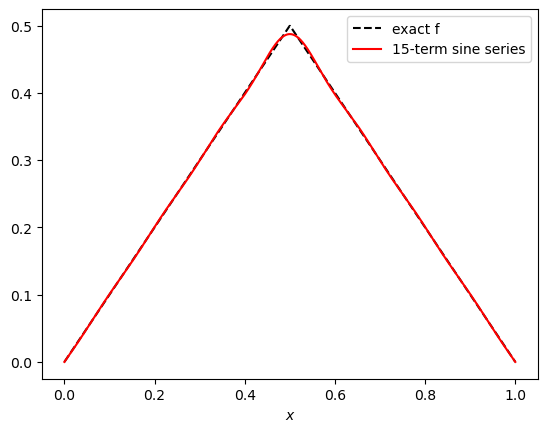

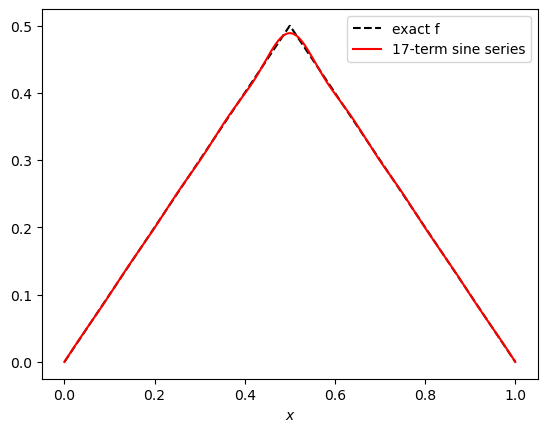

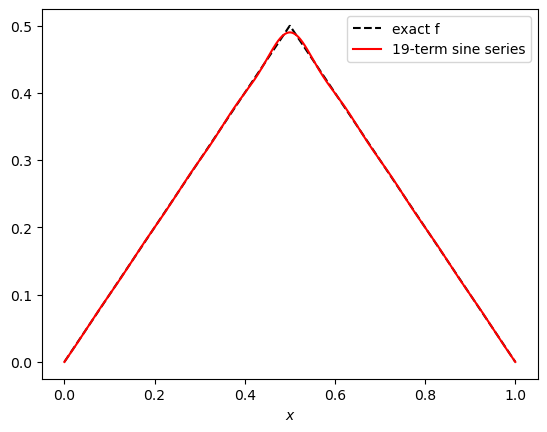

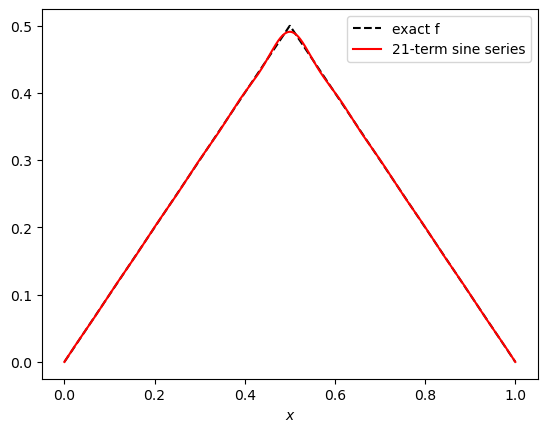

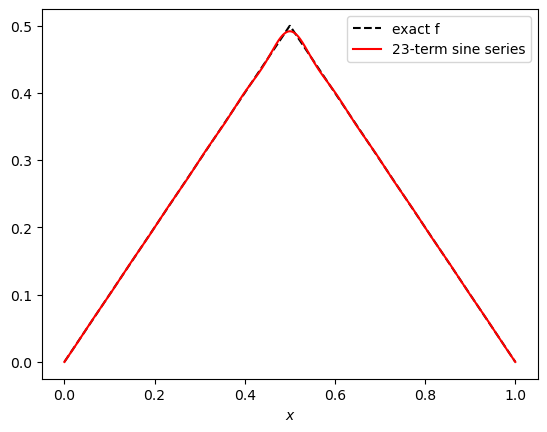

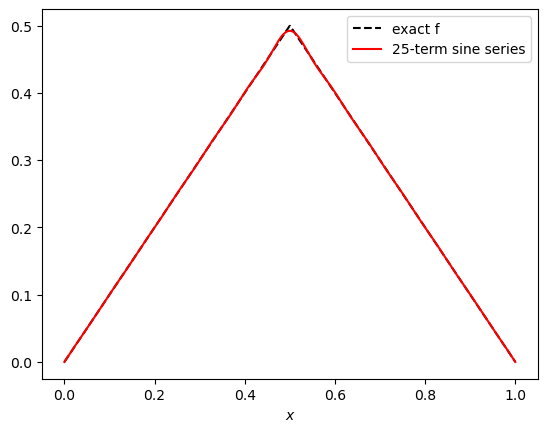

In [6]:
#using Interact
fig = figure()
x = range(0,1, 1000)
#@manipulate for n=1:2:99
for n = 1:2:25
    display(
    withfig(fig) do
        plot(x, f.(x), "k--")
        b = sinecoef.(f, 1:n)
        plot(x, [sinesum(b, x) for x in x], "r-")
        xlabel(L"$x$")
        legend(["exact f", "$n-term sine series"])
    end
    )
end

In contrast, if we make a smoother function, e.g. $g(x) = \sin(\sin(3 \pi x) + 5\sin(\pi x))$, then it eventually converges *much* more quickly (in fact, for a smooth function like this the series converges *exponentially* fast):

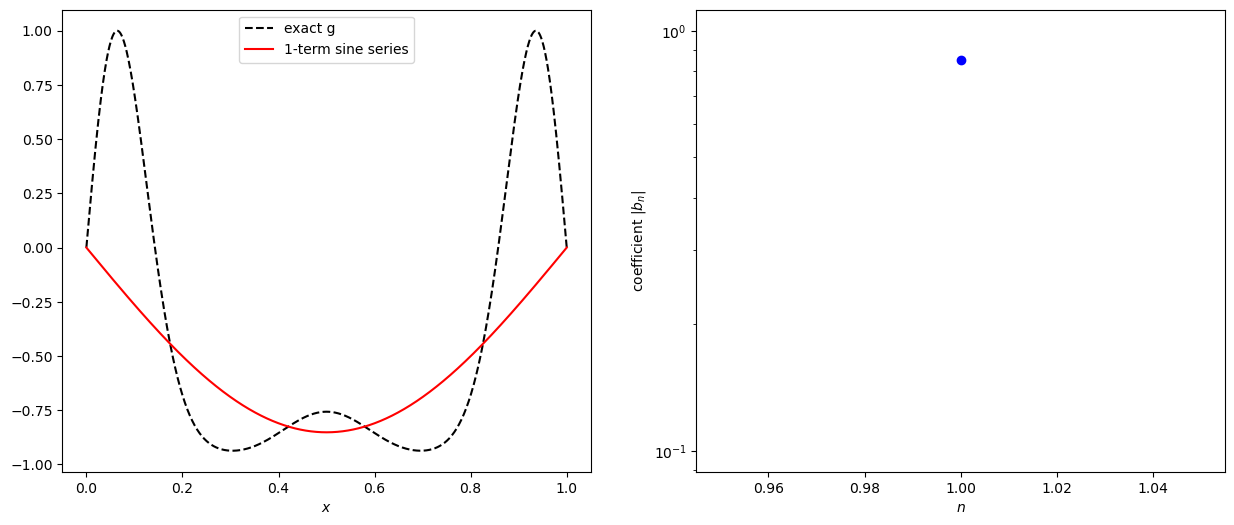

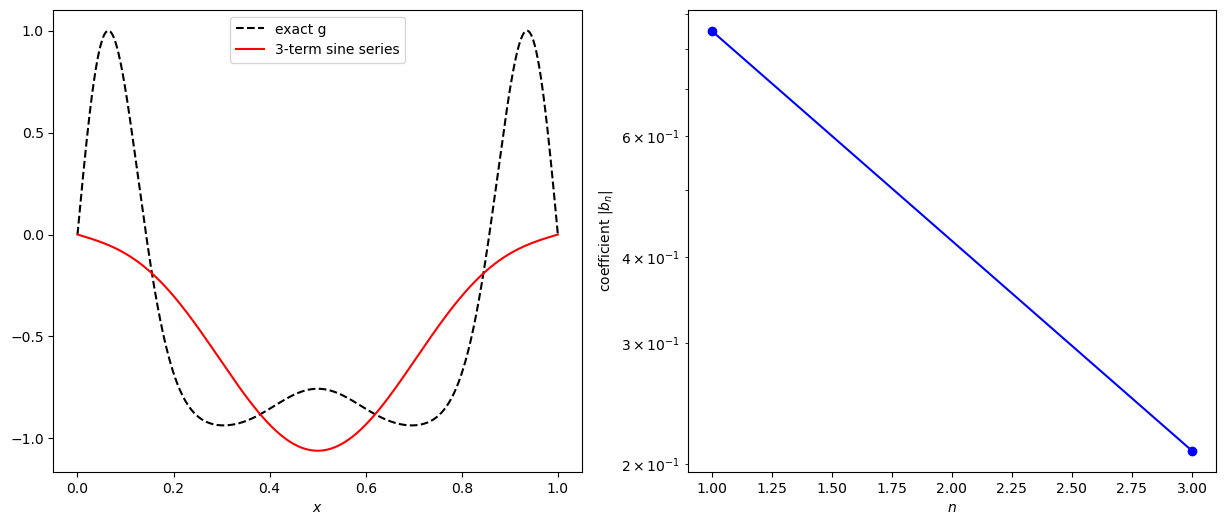

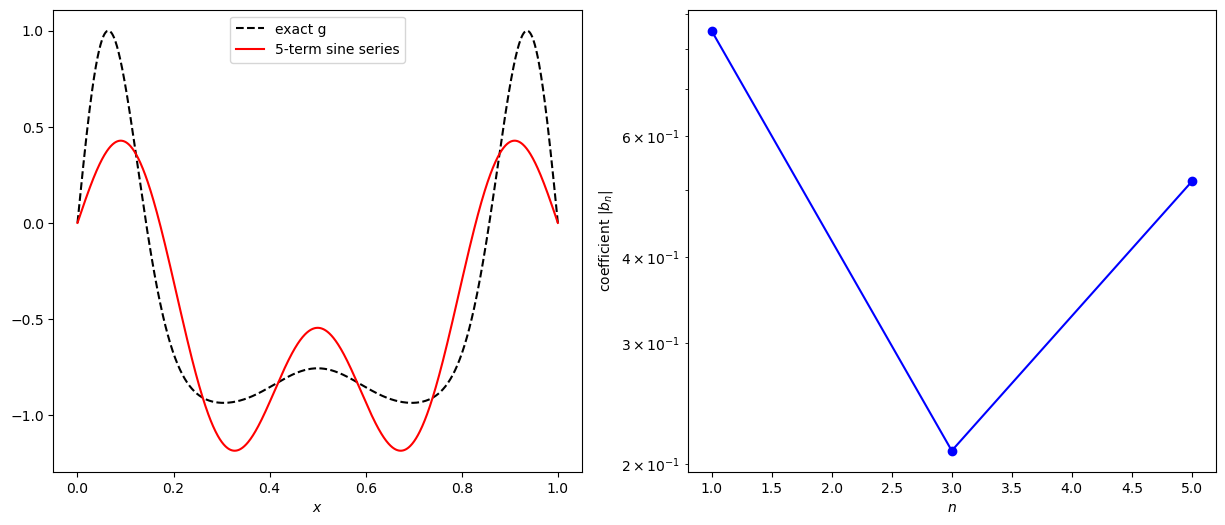

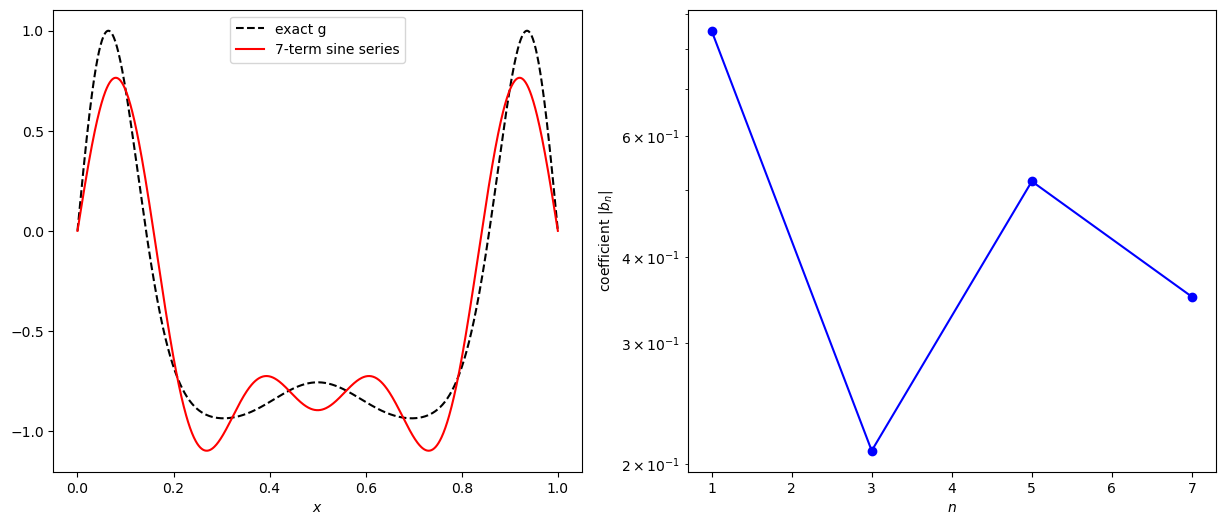

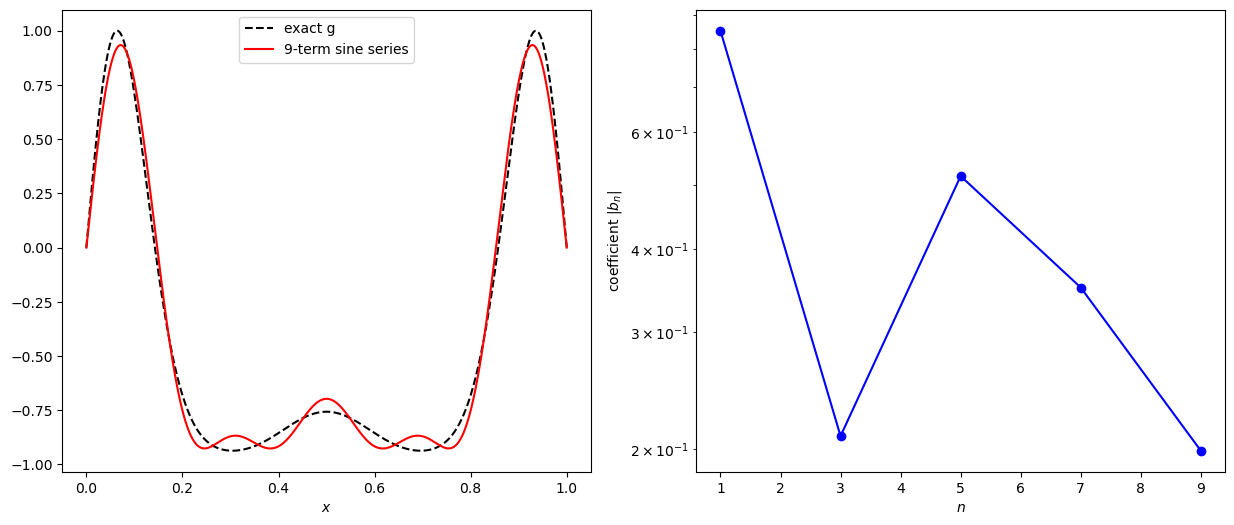

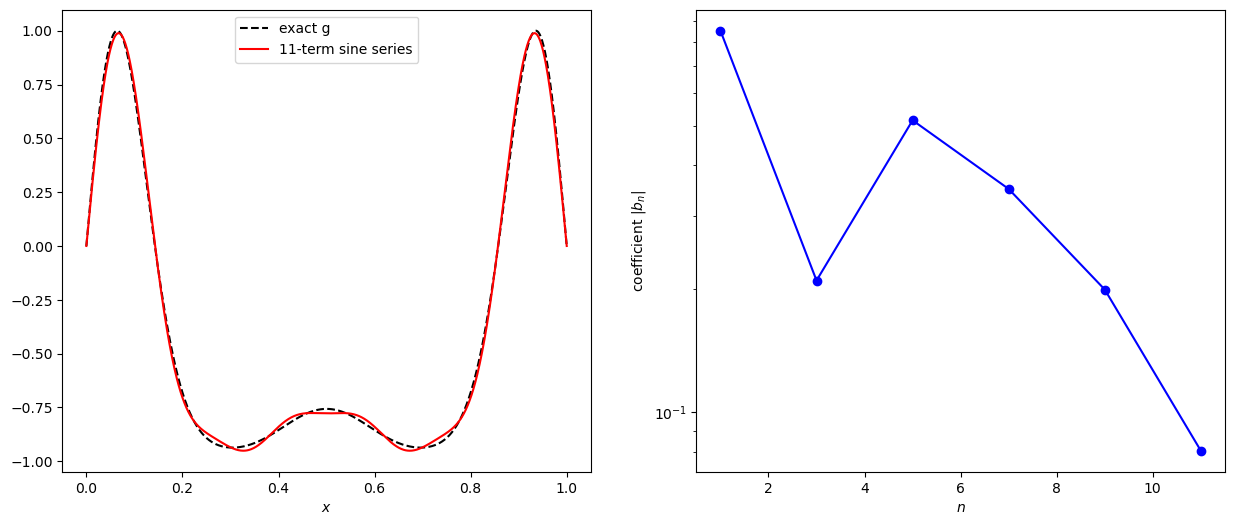

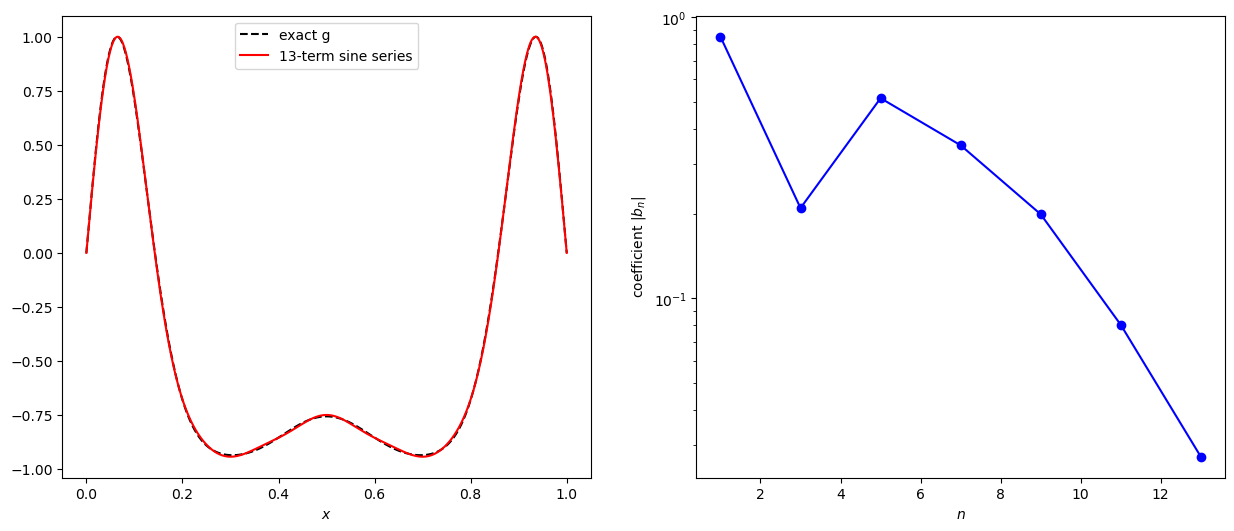

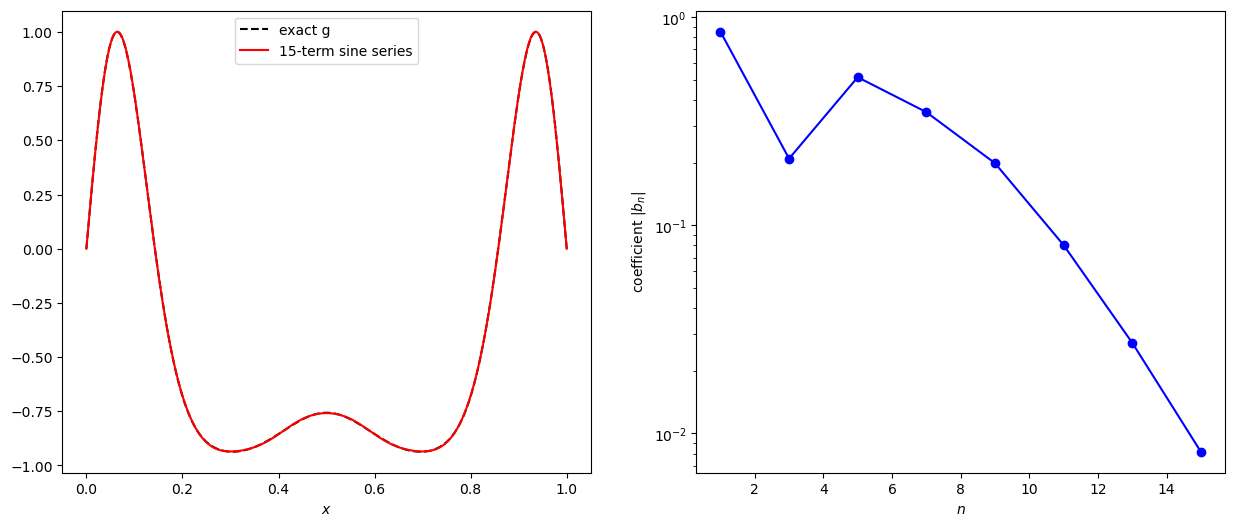

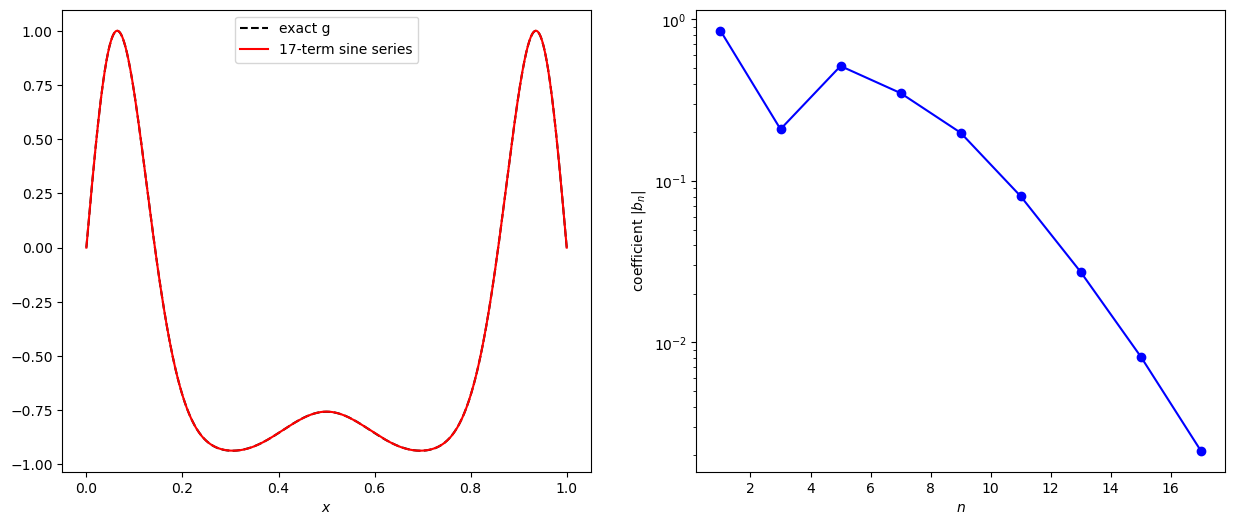

In [7]:
fig = figure(figsize=(15,6))
g(x) = sin(sin(3π*x) + 5*sin(π*x))
# @manipulate for n=1:2:37
for n=1:2:17
    display(
    withfig(fig) do
        subplot(1,2,1)
        plot(x, g.(x), "k--")
        b = sinecoef.(g, 1:n)
        plot(x, [sinesum(b, x) for x in x], "r-")
        xlabel(L"x")
        legend(["exact g", "$n-term sine series"])
        
        subplot(1,2,2)
        semilogy(1:2:n, abs.(b[1:2:n]), "bo-")
        xlabel(L"n")
        ylabel(L"coefficient $|b_n|$")
    end
    )
end

# Supplementary material

The following material goes a bit beyond 18.06 (see e.g. 18.303), but it is provided as a supplement.

## Solving the heat/diffusion equation

If we have the heat equation $\frac{\partial^2 u}{\partial x^2} = \frac{\partial u}{\partial t}$, with Dirichlet boundary conditions $u(0,t) = u(1,t) = 0$, and initial condition $u(x,0) = f(x)$, we can solve the equation by expanding $u(x,t)$ in a Fourier sine series.  From class:

* $u(x,t) = \sum_{n=0}^\infty b_n \sin(n\pi x) e^{-(n\pi)^2 t}$

where $b_n$ are the sine-series coefficients of the initial condition $f(x)$.

Let's plot this for different times $t$ for the $f(x) = 0.5 - |x - 0.5|$ from above, using 199 terms in the series:

In [8]:
using Interact

WebIO._IJuliaInit()

In [9]:
fig = figure()
@manipulate for t in slider(0:0.001:1, value=0.0, label="time t")
    withfig(fig) do
        b = @. sinecoef(f, 1:199) * exp(-((1:199)*π)^2 * t)
        plot(x, [sinesum(b, x) for x in x])
        xlabel(L"x")
        title("diffusion solution at time $t")
        ylim(0,0.5)
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time t"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 1001, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000138076770, Task (runnable) @0x0000000138076770), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.001\",\"0.002\",\"0.003\",\"0.004\",\"0.005\",\"0.006\",\"0.007\",\"0.008\",\"0.009\",\"0.01\",\"0.011\",\"0.012\",\"0.013\",\"0.014\",\"0.015\",\"0.016\",\"0.017\",\"0.018\",\"0.019\",\"0.02\",\"0.021\",\"0.022\",\"0.023\",\"0.024\",\"0.025\",\"0.0

Notice that the sharp kink (the slope discontinuity) "diffuses away" almost immediately, because that sharp kink is created by the high-frequency sine-series terms that decay very rapidly.  After a short while, in fact, the solution just looks like $\sin(\pi x)$, because it is dominated by the $n=1$ term in the series.

## Solving the wave equation

If we have the *wave* equation $\frac{\partial^2 u}{\partial x^2} = \frac{\partial^2 u}{\partial t^2}$, with Dirichlet boundary conditions $u(0,t) = u(1,t) = 0$, and initial conditions $u(x,0) = f(x)$ and $\dot{u}(x,0) = 0$, we can also solve the equation by expanding $u(x,t)$ in a Fourier sine series.  From class:

* $u(x,t) = \sum_{n=0}^\infty b_n \sin(n\pi x) \cos{n\pi t}$

where $b_n$ are the sine-series coefficients of the initial condition $f(x)$.

Let's again plot this for different times $t$ for the $f(x) = 0.5 - |x - 0.5|$ from above, using 199 terms in the series:

In [10]:
fig = figure()
@manipulate for t in slider(0:0.01:10, value=0.0, label="time t")
    withfig(fig) do
        b = @. sinecoef(f, 1:199) * cos(((1:199)*π) * t)
        plot(x, [sinesum(b, x) for x in x])
        xlabel(L"x")
        title("wave solution at time $t")
        ylim(-0.5,0.5)
        grid()
    end
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["time t"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 1001, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
1, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/stevenj/.julia/packages/Knockout/3gjS1/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/all.js"), Asset("css", nothing, "/Users/stevenj/.julia/packages/InteractBase/o1I6G/src/../assets/style.css"), Asset("css", nothing, "/Users/stevenj/.julia/packages/Interact/pVyN2/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00000001363a3dc0, Task (runnable) @0x00000001363a3dc0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.01\",\"0.02\",\"0.03\",\"0.04\",\"0.05\",\"0.06\",\"0.07\",\"0.08\",\"0.09\",\"0.1\",\"0.11\",\"0.12\",\"0.13\",\"0.14\",\"0.15\",\"0.16\",\"0.17\",\"0.18\",\"0.19\",\"0.2\",\"0.21\",\"0.22\",\"0.23\",\"0.24\",\"0.25\",\"0.26\",\"0.27\",\"0.28\",\"0

Now we have an oscillating wave, which bounced up and down between two triangle shapes.

(This may seem unrealistic to you: if you actually stretch a string into a triangle shape and let it go, it doesn't retain the sharp kinks seen here.  That is due to an effect called *dispersion* that we are not including in the wave equation...yet.)